In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

import datetime
import requests
from tqdm import tqdm

from statsmodels.tsa.arima.model import ARIMA
import holidays

from watermark import watermark

print(watermark())

Last updated: 2024-05-25T11:38:49.138892+03:00

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.21.0

Compiler    : GCC 13.2.1 20240503
OS          : Linux
Release     : 6.9.0-gentoo
Machine     : x86_64
Processor   : AMD Ryzen 9 5950X 16-Core Processor
CPU cores   : 32
Architecture: 64bit



## Загрузка данных

In [4]:
time_history_url = "https://deepstatemap.live/api/history/public"

In [8]:
# Making a get request
response = requests.get(time_history_url)

df = pd.DataFrame()
# print json content
t = len(response.json())
Path("data/").mkdir(exist_ok=True)
with tqdm(total=t) as pbar:
    for n, i in enumerate(response.json()):
        timestamp = i["id"]
        time_index = datetime.datetime.fromtimestamp(timestamp)
        pbar.set_description(str(time_index.date()), refresh=True)

        area = requests.get(
            f"https://deepstatemap.live/api/history/{timestamp}/areas")
        js_df = pd.json_normalize(area.json()).assign(time_index=time_index)
        df = pd.concat([df, js_df], ignore_index=True)
        pbar.update(1)
df

2024-05-25: 100%|██████████| 924/924 [04:03<00:00,  3.79it/s]


,hash,area,percent,type,time_index
0,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 15:33:28
1,#880e4f,46937.208199,7.775,occupied_to_24_02_2022,2022-04-03 15:33:28
2,#bcaaa4,5587.522472,0.926,unspecified,2022-04-03 15:33:28
3,#0f9d58,14012.882652,2.321,liberated,2022-04-03 15:33:28
4,#a52714,63864.643990,10.579,occupied_after_24_02_2022,2022-04-03 19:46:15
...,...,...,...,...,...
4687,#bcaaa4,648.501175,0.107,unspecified,2024-05-25 01:25:48
4688,#0f9d58,42973.097700,7.118,liberated,2024-05-25 01:25:48
4689,#ff5252,139991.513798,23.189,other_territories,2024-05-25 01:25:48
4690,#880e4f,43974.034421,7.284,occupied_to_24_02_2022,2024-05-25 01:25:48


In [10]:
df.set_index("time_index", inplace=True)
df = df.astype(
    {"percent": "float32", "area": "float64", "hash": "string", "type": "category"}
)

In [11]:
df.to_csv(Path("data/area_history.csv"))

# Моделирование краткосрочного момента


In [12]:
try:
    df
except NameError:
    df = None
if df is None:
    td = (
        datetime.datetime.now().timestamp()
        - Path("data/area_history.csv").stat().st_ctime
    )
    if td >= 60 * 60 * 24:
        print("Данные устарели!")
    df = pd.read_csv(
        Path("data/area_history.csv"),
        index_col="time_index",
        parse_dates=True,
        dtype={
            "percent": "float32",
            "area": "float64",
            "hash": "string",
            "type": "category",
        },
    )

In [13]:
area_dinamic = (
    df.dropna()
    .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]
    .mean()
    .reset_index()
    .set_index("time_index")
)
last_date = df.index.max().strftime("%Y-%m-%d %X")

/tmp/ipykernel_9991/3457041684.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([pd.Grouper(freq="D"), "type"])[["area", "percent"]]


In [14]:
area_dinamic.dropna(inplace=True)
area_dinamic["type"]

time_index
2022-04-03                    liberated
2022-04-03    occupied_after_24_02_2022
2022-04-03       occupied_to_24_02_2022
2022-04-03                  unspecified
2022-04-04                    liberated
                        ...            
2024-05-25                    liberated
2024-05-25    occupied_after_24_02_2022
2024-05-25       occupied_to_24_02_2022
2024-05-25            other_territories
2024-05-25                  unspecified
Name: type, Length: 3494, dtype: category
Categories (5, object): ['liberated', 'occupied_after_24_02_2022', 'occupied_to_24_02_2022', 'other_territories', 'unspecified']

In [15]:
ru_holidays = holidays.country_holidays("RU")
ua_holidays = holidays.country_holidays("UA")

In [16]:
target_area = 118370
svo_end = pd.to_datetime("2026-11-15")

In [17]:
aa = area_dinamic[area_dinamic["type"] == "occupied_after_24_02_2022"][
    "area"
]  # ["percent"]
aa = pd.DataFrame(
    index=pd.date_range(start=aa.index.min(), end=aa.index.max(), freq="D")
).join(aa)
aa.interpolate(inplace=True)
aa

,area
2022-04-03,63714.938326
2022-04-04,64256.540524
2022-04-05,64193.626525
2022-04-06,64261.353774
2022-04-07,65046.306239
...,...
2024-05-21,65140.808203
2024-05-22,65141.514897
2024-05-23,65143.511630
2024-05-24,65144.012024


In [18]:
xx = (
    pd.DataFrame(index=aa.index).assign(
        ru_holiday=lambda x: [d in ru_holidays for d in x.index],
        ua_holiday=lambda x: [d in ua_holidays for d in x.index],
    )
).astype("int")
xx

,ru_holiday,ua_holiday
2022-04-03,0,0
2022-04-04,0,0
2022-04-05,0,0
2022-04-06,0,0
2022-04-07,0,0
...,...,...
2024-05-21,0,0
2024-05-22,0,0
2024-05-23,0,0
2024-05-24,0,0


In [19]:
best_model = None
for p in range(5):
    for d in range(2):
        for q in range(5):
            mod = ARIMA(aa, order=(p, d, q)).fit()
            if best_model is None or best_model.aic > mod.aic:
                best_model = mod
best_model.summary()

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/v_0ver/ven

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   area   No. Observations:                  784
Model:                 ARIMA(4, 0, 3)   Log Likelihood               -5171.927
Date:                Sat, 25 May 2024   AIC                          10361.854
Time:                        12:04:32   BIC                          10403.834
Sample:                    04-03-2022   HQIC                         10377.996
                         - 05-25-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.814e+04      0.114      6e+05      0.000    6.81e+04    6.81e+04
ar.L1          1.4828      0.018     82.422      0.000       1.448       1.518
ar.L2         -1.3842      0.021    -64.843      0.000      -1.426      -1.342
ar.L3          1.4915      0.013    116.344      0.000       1.466       1.517
ar.L4         -0.5902      0.013    -46.530      0.000      -0.615      -0.565
ma.L1          0.3719      0.022     16.950      0.000       0.329       0.415
ma.L2          0.9301      0.022     43.001      0.000       0.888       0.973
ma.L3          0.1709      0.025      6.819      0.000       0.122       0.220
sigma2      2.956e+04    349.146     84.672      0.000    2.89e+04    3.02e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             80879.86
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.00   Skew:                            -1.71
Prob(H) (two-sided):                  0.00   Kurtosis:                        52.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.05e+18. Standard errors may be unstable.
"""

In [20]:
fh = 120  # int(365.25 * 5)
fcst = best_model.get_forecast(fh, alpha=0.05).summary_frame()
fcst.index = pd.date_range(
    start=aa.index.max() + pd.DateOffset(days=1), periods=fcst.shape[0], freq="D"
)
fcst

/home/v_0ver/venv/myds312/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


area,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-05-26,65147.887038,171.938010,64810.894731,65484.879345
2024-05-27,65156.207693,362.284836,64446.142461,65866.272924
2024-05-28,65164.070492,535.812401,64113.897483,66214.243500
2024-05-29,65161.058969,686.891018,63814.777313,66507.340626
2024-05-30,65157.776653,829.484349,63532.017203,66783.536104
...,...,...,...,...
2024-09-18,65209.023054,5423.471511,54579.214222,75838.831886
2024-09-19,65209.308688,5447.028308,54533.329381,75885.287995
2024-09-20,65211.365549,5470.610449,54489.166096,75933.565001
2024-09-21,65211.700248,5493.789338,54444.071006,75979.329489


In [21]:
svo_end_alpha = 99.95
svo_end_km_ration = 0.01
hh = fcst[["mean", "mean_se"]].diff() / fcst[["mean", "mean_se"]].abs()
end_svo = hh[
    (hh["mean_se"] <= 1 - svo_end_alpha / 100) & (hh["mean"] <= svo_end_km_ration / 100)
].index.min()
fcst = fcst[:end_svo]
# fh = fcst.shape[0]
fh = 90

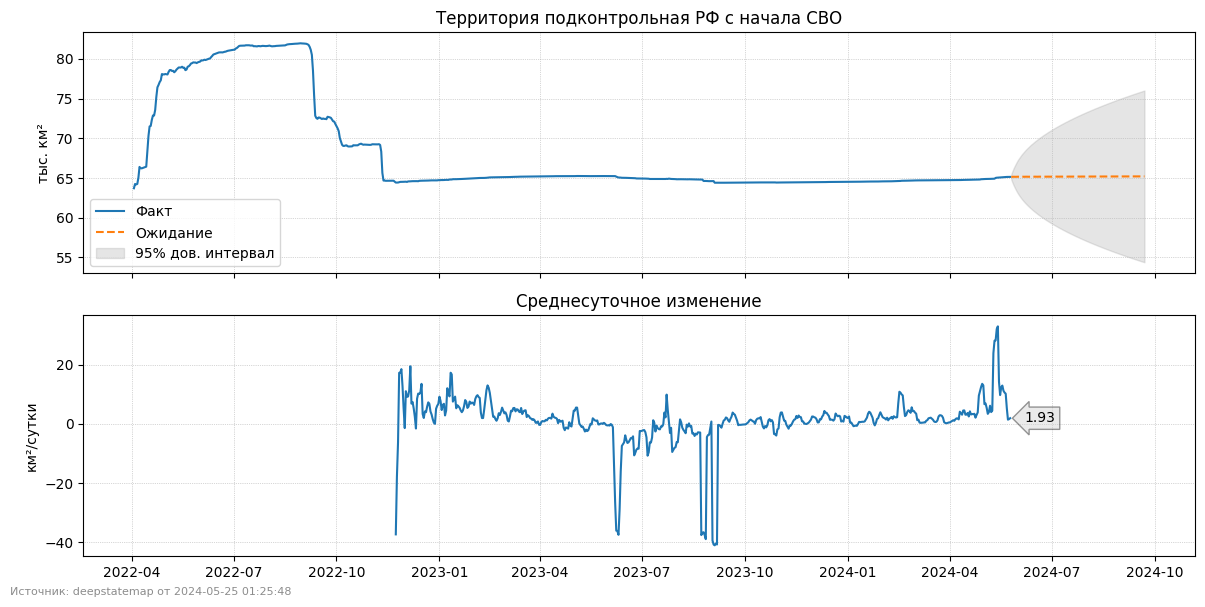

In [22]:
# sns.set_style("whitegrid")
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12, 6))
ax = axs[0]
sns.lineplot(aa["area"] / 1000, ax=ax, label="Факт")
sns.lineplot(fcst["mean"] / 1000, ls="--", ax=ax, label="Ожидание")
fill_95p = ax.fill_between(
    fcst.index,
    fcst["mean_ci_lower"] / 1000,
    fcst["mean_ci_upper"] / 1000,
    alpha=0.2,
    color="grey",
)
fill_95p.set_label("95% дов. интервал")
ax.legend()
ax.set(
    xlabel=None,
    ylabel="тыс. км\u00b2",
    title="Территория подконтрольная РФ с начала СВО",
)
ax = axs[1]
ax.set(
    xlabel=None,
    ylabel="км\u00b2/сутки",
    title="Среднесуточное изменение",
)
day_din_area = (
    aa.diff()["2022-11-23":].rolling(5, center=True, min_periods=int(5 / 2)).mean()
)
sns.lineplot(
    day_din_area,
    ax=ax,
    legend=None,
)
bbox = dict(boxstyle="larrow", fc="0.8", alpha=0.4)
dy = day_din_area.iloc[-1].values[0]
dx = day_din_area.index.max()
ax.annotate(
    f"{dy:.2f}",
    (dx + datetime.timedelta(days=12 + int(fh / 60)), dy),
    # xytext=(-2, 1),
    bbox=bbox,
    va="center",
    ha="left",
)
for ax in axs:
    ax.grid(ls=":", lw=0.5)
fig.tight_layout()
fig.text(
    0,
    0,
    f"Источник: deepstatemap от {last_date}",
    fontdict={"size": 8},
    alpha=0.45,
)
Path("img/").mkdir(exist_ok=True)
fig.savefig(Path("img/area.png"), format="png", dpi=300)